In [1]:
import math
import numpy as np
from scipy import constants
import scipy
import matplotlib.pyplot as plt
import mpmath as mp

eta = 1e-3
rho_f = 700
temp = 293

m = 5e-13
K = 1e-6
r = 3e-6

def hydro_msd(t):
    trap_const = K
    use_mass = m
    m_f = 2 / 3 * np.pi * r ** 3 * 1000
    t_k = (6 * np.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    print(t_p)
    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0
    a_ = t_p
    b = -1 * np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    # Coefficients array for the polynomial equation
    coefficients = [a_, b, c, d, e]

    # Find the roots
    roots = np.roots(coefficients)

    # I need to learn how to vectorize my code better
    term_1 = scipy.special.erfcx(roots[0] * np.sqrt(t)) / (
                roots[0] * (roots[0] - roots[1]) * (roots[0] - roots[2]) * (roots[0] - roots[3]))
    term_2 = scipy.special.erfcx(roots[1] * np.sqrt(t)) / (
                roots[1] * (roots[1] - roots[0]) * (roots[1] - roots[2]) * (roots[1] - roots[3]))
    term_3 = scipy.special.erfcx(roots[2] * np.sqrt(t)) / (
                roots[2] * (roots[2] - roots[1]) * (roots[2] - roots[0]) * (roots[2] - roots[3]))
    term_4 = scipy.special.erfcx(roots[3] * np.sqrt(t)) / (
                roots[3] * (roots[3] - roots[1]) * (roots[3] - roots[2]) * (roots[3] - roots[0]))

    D = constants.k * temp / (6 * np.pi * eta * r)
    # Returns theoretical MSD
    return np.real(2 * constants.k * temp / trap_const + 2 * constants.k * temp / (use_mass) * (
                term_1 + term_2 + term_3 + term_4))

def VACF_init_conditions_hydro(t, m, K, r):
    t_k = (6 * math.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * math.pi * r * eta)

    # find roots
    # a * z^4 + b * z^3 + c * z^2 + d * z + e = 0

    a = t_p #+ (1 / 9.0) * t_f
    b = -np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    coefficients = [a, b, c, d, e]

    roots = np.roots(coefficients)
    print("roots: " + str(roots))

    term1 = (1/m) * sum(
        (roots[i] ** 3 * scipy.special.erfcx(roots[i] * np.sqrt(t))) /
        (np.prod([roots[i] - roots[j] for j in range(len(roots)) if i != j])) for i in range(len(roots))
    )
    big_a = np.real(term1)
    term2 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)
    big_b = np.real(term2)
    az = (1/m) * sum(
        (z ** 3  * scipy.special.erfcx(z * np.sqrt(1e-20))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots
    )
    a_zero = np.real(az)
    bz = (1/m) * sum(
        (z* scipy.special.erfcx(z * np.sqrt(1e-20))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)
    b_zero = np.real(bz)

    vacf = constants.k * temp * (big_a - m*a_zero*big_a - K*b_zero*big_b)
    return vacf


In [2]:
def compute_roots(m, K, r):
    t_k = (6 * math.pi * r * eta) / K
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * math.pi * r * eta)

    a = t_p
    b = -np.sqrt(t_f)
    c = 1
    d = 0
    e = 1 / t_k

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

def VACF_for_integral(t1, t2, m, K, roots):
    tau = np.abs(t2 - t1)
    a_diff = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(tau))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a1 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a2 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b1 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b2 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    r_term = constants.k * temp * (np.real(a_diff) - m*np.real(a1)*np.real(a2) - K*np.real(b1)*np.real(b2))
    return r_term

def integrate_t2(t1, t, m, K, roots):
    return scipy.integrate.quad(lambda t2: VACF_for_integral(t1, t2, m, K, roots), 0, t, epsabs=1e-14, epsrel=1e-14)[0]

def compute_x_squared(t, m, K, roots):
    return scipy.integrate.quad(lambda t1: integrate_t2(t1, t, m, K, roots), 0, t, epsabs=1e-14, epsrel=1e-14)[0]


In [3]:
def numerical_laplace_term3(t_, v0):
    # Use arbitrary precision
    mp.dps = 30  # number of decimal places
    # 
    
    pre_factor = (6*math.pi*r**2*math.sqrt(rho_f*eta)) * v0
    
    # Constants (you can change these)
    a = 6*math.pi*r**2*math.sqrt(rho_f*eta)
    b = m
    c = 6*math.pi*r*eta
    d = K
    g = 1
    
    # Laplace-domain function F(s)
    def F(s):
        return g * mp.sqrt(s) / (a*s**(3/2) + b*s**2 + c*s + d)
    
    # Time vector
    return pre_factor*np.array(float(mp.invertlaplace(F, t_, method='talbot')) )


In [4]:
# Generic initial V

def VACF_for_var_init_integral(t1, t2, m, K, roots, v0=8.994778007266217e-05):
    tau = np.abs(t2 - t1)
    a_diff = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(tau))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a1 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    a2 = (1/m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b1 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t1))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    b2 = (1/m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t2))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots)

    r_term = constants.k * temp * (np.real(a_diff) - m*np.real(a1)*np.real(a2) - K*np.real(b1)*np.real(b2))
    # return r_term
    inertial_init_term = v0**2 * m**2 * np.real(a1) * np.real(a2)
    numerical_term = numerical_laplace_term3(t1, v0) * numerical_laplace_term3(t2, v0)
    
    return r_term + inertial_init_term + numerical_term


def integrate_t2_var(t1, t, m, K, roots):
    return scipy.integrate.quad(lambda t2: VACF_for_var_init_integral(t1, t2, m, K, roots), 0, t, epsabs=1e-14, epsrel=1e-14)[0]

def compute_x_squared_var(t, m, K, roots):
    return scipy.integrate.quad(lambda t1: integrate_t2_var(t1, t, m, K, roots), 0, t, epsabs=1e-14, epsrel=1e-14)[0]
    

In [5]:
times = np.logspace(-7, -3, 6)
roots = compute_roots(m, K, r)

# Eq MSD
basset_msd = hydro_msd(times)

init_zero_msd = []

for t in times:
    print(f"t = {t:.2e}")
    val = compute_x_squared(t, m, K, roots)
    init_zero_msd.append(val)

8.841941282883075e-06
t = 1.00e-07
t = 6.31e-07
t = 3.98e-06
t = 2.51e-05
t = 1.58e-04
t = 1.00e-03


In [ ]:
# The initial variable case

roots = compute_roots(m, K, r)
print(roots)
init_var_hydro_msd = []

for t in times:
    print(f"t = {t:.2e}")
    val2 = compute_x_squared_var(t, m, K, roots)
    init_var_hydro_msd.append(val2)

[ 1.41958228e+02+304.8608164j   1.41958228e+02-304.8608164j
 -2.21985614e-02  +4.20525672j -2.21985614e-02  -4.20525672j]
t = 1.00e-07
t = 6.31e-07


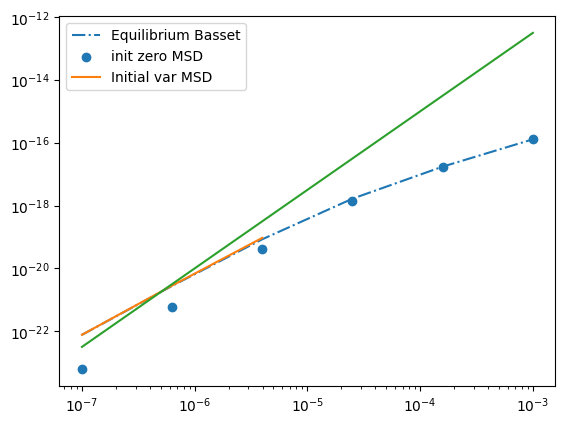

In [6]:
# PLOT VACFs

vacf = VACF_init_conditions_hydro(times, m, K, r)
plt.plot(times, vacf)
plt.title('VACF')
plt.xscale('log')
plt.yscale('log')
plt.show()

#PLOT MSDS

plt.plot(times[:30], basset_msd[:30], linestyle='dashdot', label="Equilibrium Basset")
plt.scatter(times[:30], init_zero_msd[:30], label="init zero MSD")
plt.plot(times[:3], init_var_hydro_msd, label="Initial var MSD")
# plt.xlim(right = 1E-5)
# plt.ylim(top = 1E-17, bottom = 0)
# plt.plot(times[:50], times[:50]**(3))
plt.plot(times[:50], times[:50]**(5.0/2)/1e5)
# plt.plot(times[:50], times[:50]**(2)/1e8)
plt.xscale("log")
plt.yscale("log")
plt.legend()